# Visualization of Colorado dataset

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Cleaning dataset

In [54]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            print(f"Could not parse date: {date_str}")
            return pd.NaT


def clean_data():
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv('./Preprocessing/ColoradoData.csv')

    # Strip extra whitespace from the column names
    df.columns = [col.strip() for col in df.columns]

    # Strip extra whitespace from the date columns
    df['Start_Date___Time'] = df['Start_Date___Time'].str.strip()
    df['End_Date___Time'] = df['End_Date___Time'].str.strip()

    # Now parse the datetime columns using the parse_date function
    df['Start_DateTime'] = df['Start_Date___Time'].apply(parse_date)
    df['End_DateTime'] = df['End_Date___Time'].apply(parse_date)

    # Convert duration columns to timedelta objects
    df['Total_Duration'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
    df['Charging_Time'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

    # Convert Energy consumption to a numeric type (handle errors)
    df['Energy_Consumption'] = pd.to_numeric(
        df['Energy__kWh_'], errors='coerce')

    # Remove the columns that are no longer needed
    df = df.drop(columns=['Start_Date___Time', 'End_Date___Time', 'Total_Duration__hh_mm_ss_',
                          'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'ObjectID', 'ObjectId2', 'Start_Time_Zone', 'End_Time_Zone',
                          'Port_Type', 'GHG_Savings__kg_', 'Gasoline_Savings__gallons_', 'Zip_Postal_Code', 'City'])

    # More data cleaning
    # Remove rows with negative energy consumption
    df = df[df['Energy_Consumption'] >= 0]

    # Remove rows with missing values
    df = df.dropna()

    # Remove rows with zero charging time
    df = df[df['Charging_Time'] > pd.Timedelta(0)]

    # Remove rows with zero energy consumption
    df = df[df['Energy_Consumption'] > 0]

    # Remove rows with zero total duration
    df = df[df['Total_Duration'] > pd.Timedelta(0)]

    # Remove rows with total duration less than charging time
    df = df[df['Total_Duration'] >= df['Charging_Time']]

    # Sort the data by the Start_DateTime column
    df = df.sort_values(by=['Start_DateTime'], ascending=True)

    # Save the cleaned data to a new CSV file
    #df.to_csv('TestDataset/CleanedColoradoData.csv')

    df = df.reset_index(drop=True)

    df = df.drop_duplicates(subset=['Start_DateTime', 'End_DateTime', 'Energy_Consumption', 'Total_Duration', 'Charging_Time'], keep="last")

    return df


df = clean_data()

print(df.head())

                      Station_Name             Address   State_Province  \
1  BOULDER / JUNCTION ST1           2280 Junction Pl    Colorado          
3  BOULDER / JUNCTION ST1           2280 Junction Pl    Colorado          
5  BOULDER / JUNCTION ST1           2280 Junction Pl    Colorado          
7  BOULDER / ALPINE ST1             1275 Alpine Ave     Colorado          
9  BOULDER / BASELINE ST1           900 Baseline Rd     Colorado          

       Start_DateTime        End_DateTime  Total_Duration   Charging_Time  \
1 2018-01-01 17:49:00 2018-01-01 19:52:00 0 days 02:03:02 0 days 02:02:44   
3 2018-01-02 08:52:00 2018-01-02 09:16:00 0 days 00:24:34 0 days 00:24:19   
5 2018-01-02 21:11:00 2018-01-03 06:23:00 0 days 09:12:21 0 days 03:40:52   
7 2018-01-03 09:19:00 2018-01-03 11:14:00 0 days 01:54:51 0 days 01:54:29   
9 2018-01-03 14:13:00 2018-01-03 14:30:00 0 days 00:16:58 0 days 00:16:44   

   Energy_Consumption  
1               6.504  
3               2.481  
5             

## General Information about dataset

In [78]:
# What is the average energy consumption per hour?
df['Energy_Consumption_per_hour'] = df['Energy_Consumption'] / df['Total_Duration'].dt.total_seconds() * 3600
avg_energy_consumption_per_hour = df['Energy_Consumption_per_hour'].mean()

# What is the total energy consumption for each year?
total_energy_consumption_per_year = df.groupby('Year')['Energy_Consumption'].sum()

# How many induviduel charging sessions are there for each year?
charging_sessions_per_year = df['Year'].value_counts()

# How many charging stations are in the dataset?
charging_stations = df['Station_Name'].nunique()

# How many charging stations have the same address?
station_counts = df['Station_Name'].value_counts()

# How many charging sessions are there for each station?
charging_sessions_per_station = df['Station_Name'].value_counts()

# 10 most common charging stations each year with average energy consumption per hour
top_10_stations_per_year = df.groupby('Year')['Station_Name'].value_counts().groupby('Year').head(10)

# Count number of sessions per Station per Year
station_countss = (
    df.groupby(["Year", "Station_Name"])
    .size()
    .reset_index(name="Session_Count")  # Convert to DataFrame
)

# Sort by Year and Session Count (descending)
station_countss = station_countss.sort_values(["Year", "Session_Count"], ascending=[True, False])

# Get top 10 stations per year
top_10_stations_per_year = station_countss.groupby("Year").head(10)

print("###################### Colorado data statistics ##############################")
print(f"How many charging sessions: {len(df)}")
print(f"Charging stations in the dataset: {charging_stations}")
print(f"Average energy consumption per hour: {avg_energy_consumption_per_hour} kWh")
print("#################################################################################")

###################### Colorado data statistics ##############################
How many charging sessions: 75778
Charging stations in the dataset: 50
Average energy consumption per hour: 4.4123947261667515 kWh
#################################################################################


## Plotting Dataset

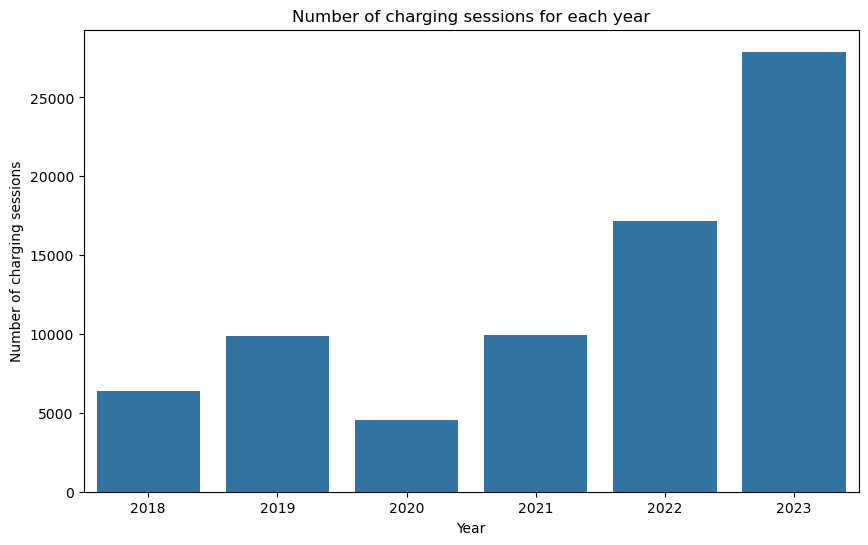

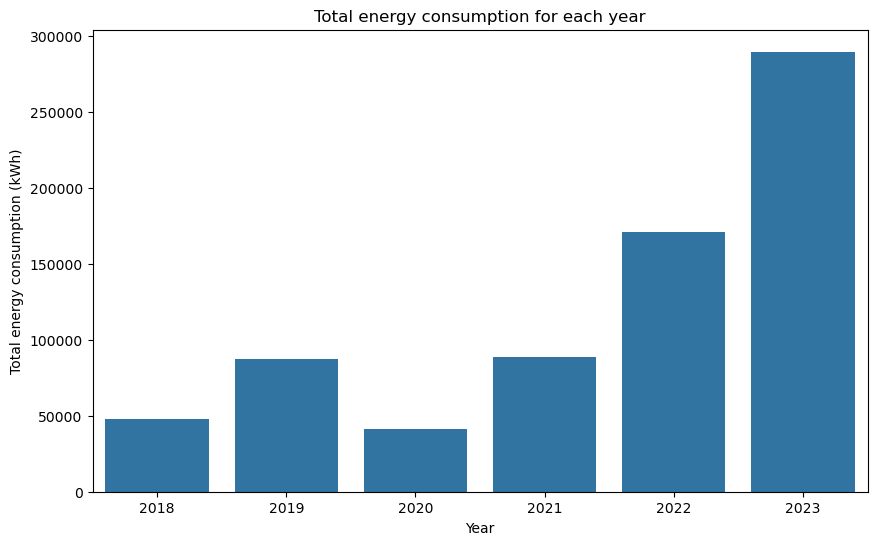

In [77]:
# Plotting the data
# Plot the number of charging sessions for each year
plt.figure(figsize=(10, 6))
sns.barplot(x=charging_sessions_per_year.index,
            y=charging_sessions_per_year.values)
plt.title('Number of charging sessions for each year')
plt.xlabel('Year')
plt.ylabel('Number of charging sessions')
plt.show()

# Plot the total energy consumption for each year
plt.figure(figsize=(10, 6))
sns.barplot(x=total_energy_consumption_per_year.index,
            y=total_energy_consumption_per_year.values)
plt.title('Total energy consumption for each year')
plt.xlabel('Year')
plt.ylabel('Total energy consumption (kWh)')
plt.show()

## Charging Stations 

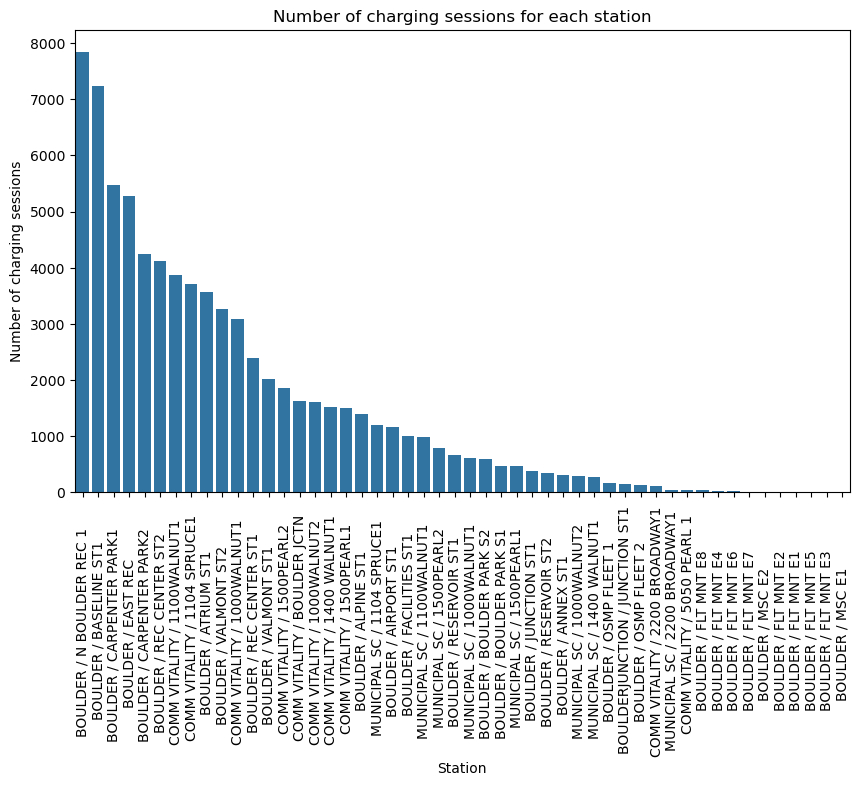

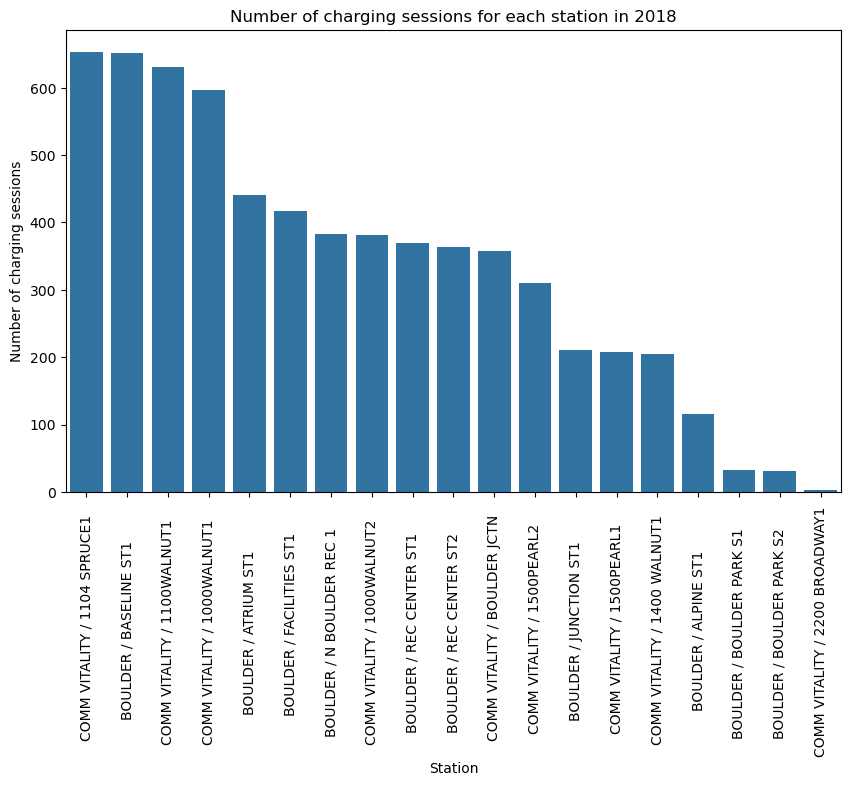

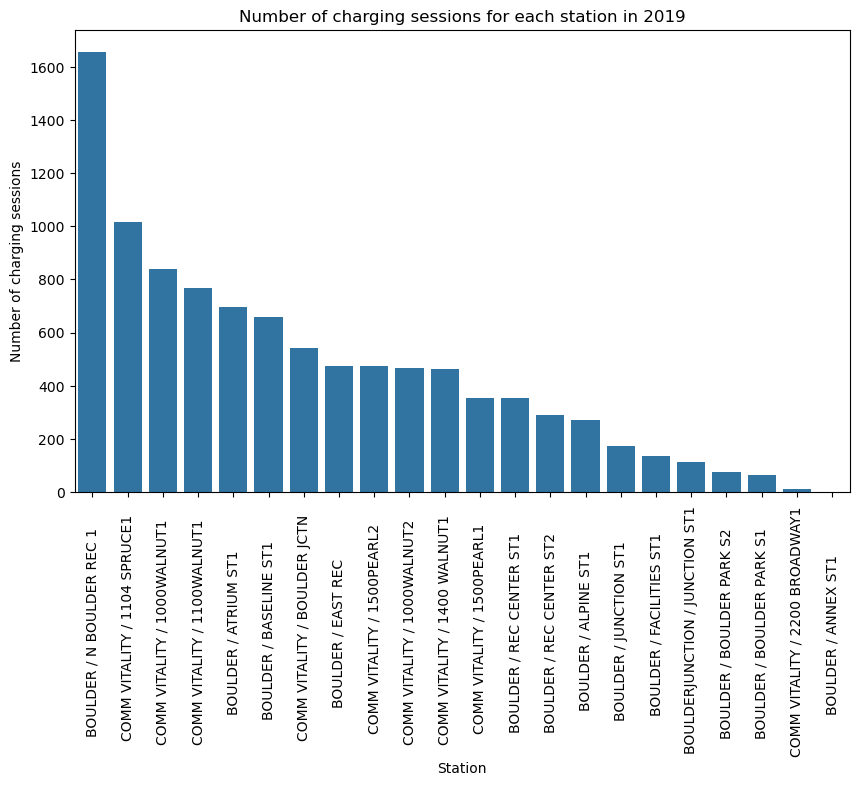

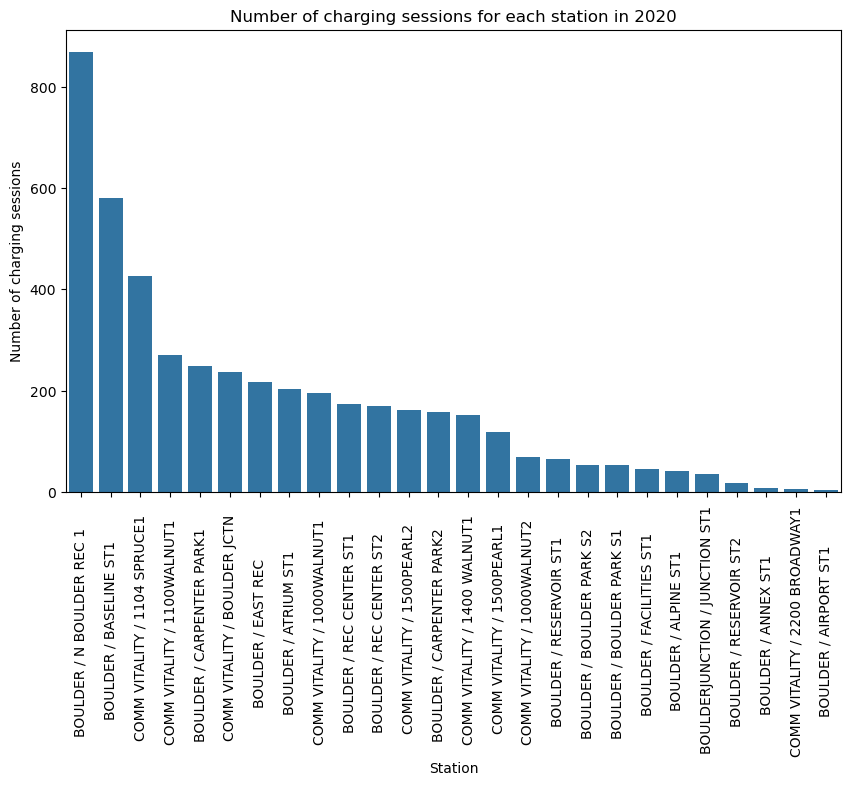

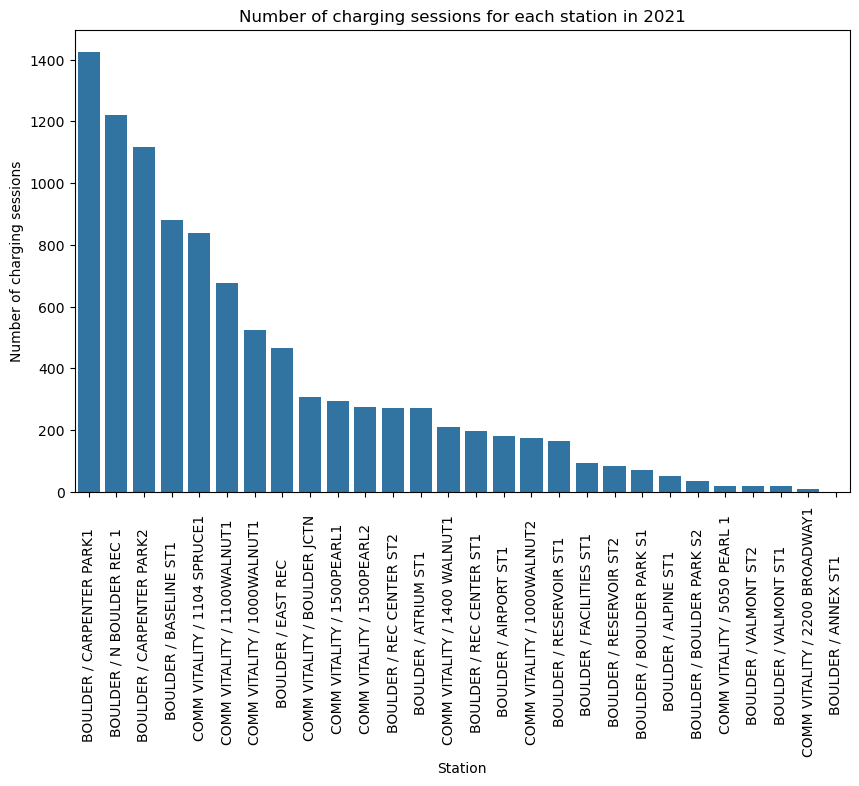

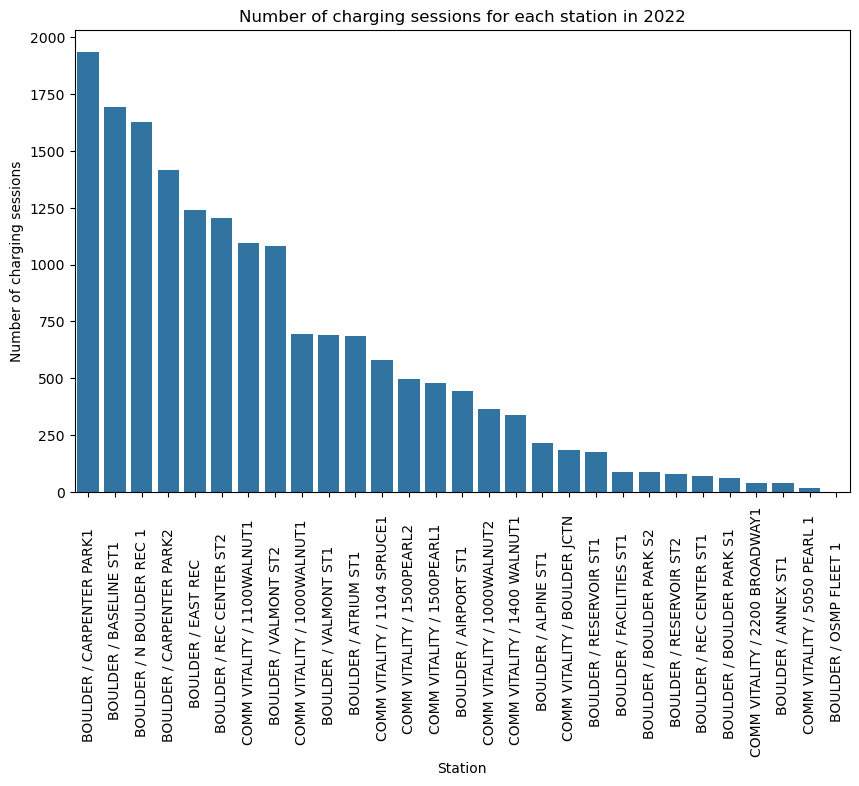

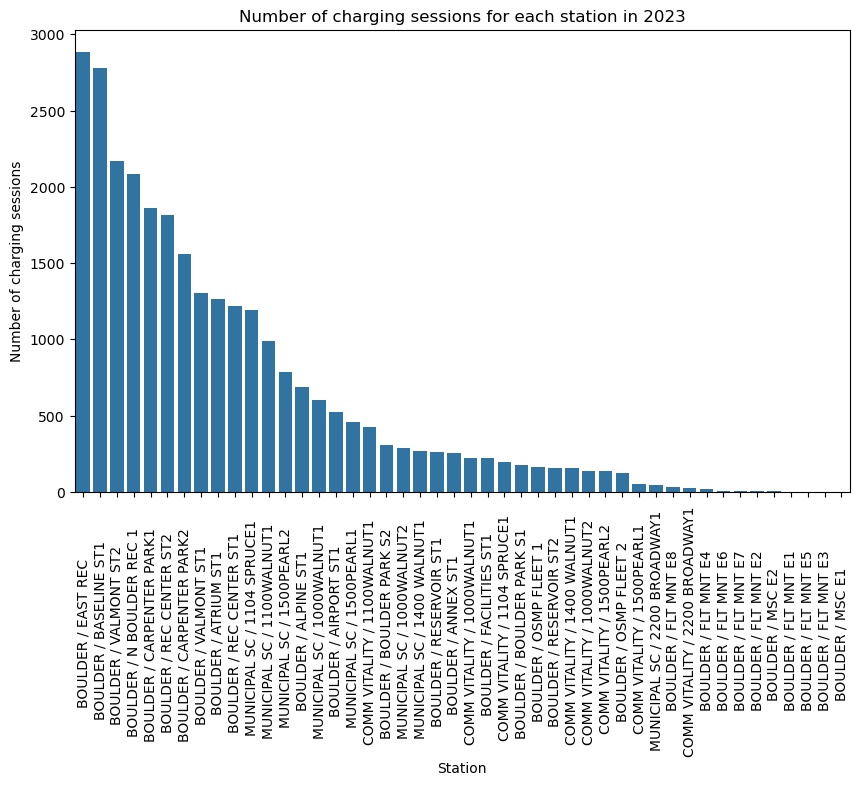

In [67]:
# Number of charging sessions for each station
plt.figure(figsize=(10, 6))
sns.barplot(x=charging_sessions_per_station.index, y=charging_sessions_per_station.values)
plt.title('Number of charging sessions for each station')
plt.xlabel('Station')
plt.ylabel('Number of charging sessions')
plt.xticks(rotation=90)
plt.show()


# For loop to create a plot for each year with number of charging sessions for each station
for year in df['Year'].unique():
    df_year = df[df['Year'] == year]
    charging_sessions_per_station = df_year['Station_Name'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=charging_sessions_per_station.index, y=charging_sessions_per_station.values)
    plt.title(f'Number of charging sessions for each station in {year}')
    plt.xlabel('Station')
    plt.ylabel('Number of charging sessions')
    plt.xticks(rotation=90)
    plt.show()


# For loop to create a plot for each year with top 10 charging stations with the most charging sessions
# for year in df['Year'].unique():
#     df_year = df[df['Year'] == year]
#     top_10_stations = df_year['Station_Name'].value_counts().head(10)
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=top_10_stations.index, y=top_10_stations.values)
#     plt.title(f'Top 10 charging stations with the most charging sessions in {year}')
#     plt.xlabel('Station')
#     plt.ylabel('Number of charging sessions')
#     plt.xticks(rotation=90)
#     plt.show()
